### Table of Contents
* [Chapter 1 : Présentation des données](#chapter1)
    * [Section 1.1 Chargement des données](#section_1_1)
    * [Section 1.2 Présentation d’une musique](#section_1_2)
    * [Section 1.3 Musique sous forme de signal](#section_1_3)
    * [Section 1.4 La transformée de Fourier](#section_1_4)
    * [Section 1.5 Le spectograme](#section_1_5)
    * [Section 1.6 La TF sur un song](#section_1_6)
    
   
        
* [Chapter 2 Classification sur deux classes](#chapter2)
    * [Section 2.1 Chargement données](#section_2_1)
    * [Section 2.2 Présentation algo](#section_2_2)
    * [Section 2.3 Optimisation svm](#section_2_3)
    * [Section 2.4 Résultats sur les coéfficients de fourier](#section_2_4)
    * [Section 2.5 Présentation des métriques](#section_2_5)
    * [Section 2.6 Résultats avec le mfcc](#section_2_6)
    

* [Chapter 3 Classification sur les 10 classes](#chapter3)
    * [Section 3.1 Choisir le nombre de fréquences optimal](#section_3_1)
    * [Section 3.2 the number of cepstrum to return.](#section_3_2)
    * [Section 3.3 Comparer les résultats](#section_3_3)

In [145]:
!export PATH=/Library/TeX/texbin:$PATH

In [85]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygame
import random

from scipy.io import wavfile
from scipy.fft import fft, fftfreq

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import normalize
from python_speech_features import mfcc

import seaborn as sns
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

# Chapter 1 Présentation des données <a class="anchor" id="chapter1"></a>
## Section 1.1 Chargement des données <a class="anchor" id="section_1_1"></a>

In [6]:
all_file=[]
for g in genres:
    for f in os.listdir('genres/{}'.format(g)):
        print(os.path.join(g,f))
        all_file.append(os.path.join(g,f))
all_file=['genres/'+i for i in all_file]

blues/blues.00093.wav
blues/blues.00087.wav
blues/blues.00050.wav
blues/blues.00044.wav
blues/blues.00078.wav
blues/blues.00079.wav
blues/blues.00045.wav
blues/blues.00051.wav
blues/blues.00086.wav
blues/blues.00092.wav
blues/blues.00084.wav
blues/blues.00090.wav
blues/blues.00047.wav
blues/blues.00053.wav
blues/blues.00052.wav
blues/blues.00046.wav
blues/blues.00091.wav
blues/blues.00085.wav
blues/blues.00081.wav
blues/blues.00095.wav
blues/blues.00042.wav
blues/blues.00056.wav
blues/blues.00057.wav
blues/blues.00043.wav
blues/blues.00094.wav
blues/blues.00080.wav
blues/blues.00096.wav
blues/blues.00082.wav
blues/blues.00069.wav
blues/blues.00055.wav
blues/blues.00041.wav
blues/blues.00040.wav
blues/blues.00054.wav
blues/blues.00068.wav
blues/blues.00083.wav
blues/blues.00097.wav
blues/blues.00033.wav
blues/blues.00027.wav
blues/blues.00026.wav
blues/blues.00032.wav
blues/blues.00024.wav
blues/blues.00030.wav
blues/blues.00018.wav
blues/blues.00019.wav
blues/blues.00031.wav
blues/blue

## Section 1.2 - Présentation d’une musique <a class="anchor" id="section_1_2"></a>

In [4]:
def random_file(Print=False):
    """
    
    
    """
    file=random.choice(all_file)
    if Print:  
        print(file)
    return file

def random_song(Print=False):
    """
    
    """
    file=random_file(Print)
    pygame.init()
    z=pygame.mixer.Sound(file)
    z.play()
    

In [5]:
random_song(True)

genres/jazz/jazz.00039.wav


In [6]:
pygame.mixer.pause()

## Section 1.3 - Musique sous forme de signal <a class="anchor" id="section_1_3"></a>

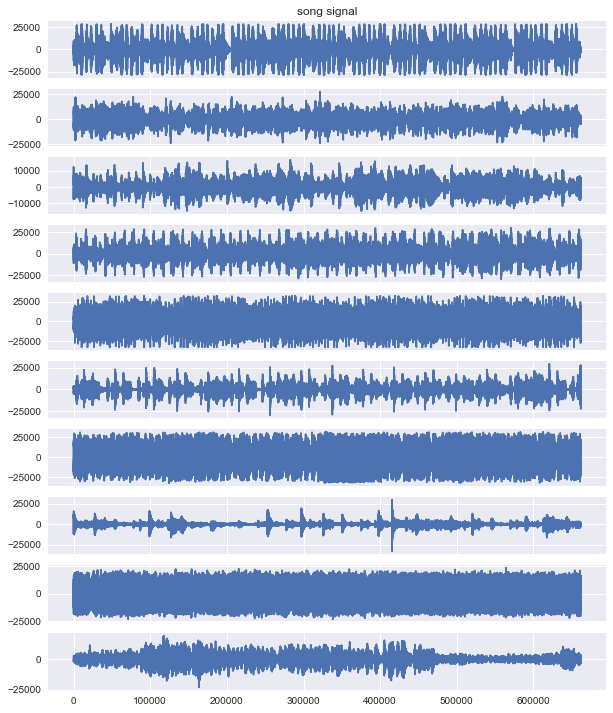

In [7]:
plt.style.use('seaborn')
f, ax = plt.subplots(10, sharex=True, sharey=False)
for i in range(10):
    ax[0].set_title('song signal')
    test=wavfile.read(random_file())
    ax[i].plot(test[1])
f.set_figheight(12.3)
f.set_figwidth(10)   
plt.show()

## Section 1.4 - La transformée de Fourier <a class="anchor" id="section_1_4"></a>

L'idée est d'extraire les caractéristiques du son (qui est un signal) et faire la classification
sur la base de ces caractéristiques en trouvant la combinaison des caractéristiques qui correspond
à chaque catégorie.

caractéristiques d'un signal :

On distingue les caractéristiques du domaines temporelle(amplitude du signal par exemple) et/ou du domaine
fréquentielle ( le spectre du son obtenu grâce à la transformée de Fourier)

C'est quoi la transformée de Fourier ?

La transformée de Fourier est une opération sur un signal, qui permet de décrire dans l'espace des
fréquences un signal dont on connaît l'histoire au cours du temps, et
réciproquement.

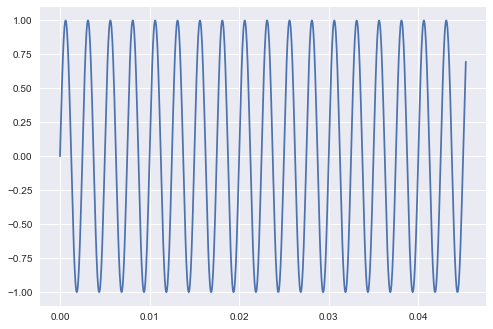

Duration : 1.0 S


In [9]:
SAMPLE_RATE = 22050  # Hertz
DURATION = 1  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)  #sin(2*pi*freq)
    return x, y


# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(400, SAMPLE_RATE, DURATION)
plt.plot(x[:1000], y[:1000])
plt.show()
print('Duration : {} S'.format(len(y)/SAMPLE_RATE))

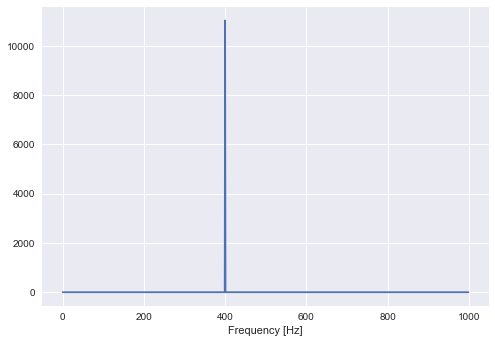

In [10]:
# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(y)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf[:1000], np.abs(yf)[:1000])
plt.xlabel('Frequency [Hz]')
plt.show()

## Section 1.5 - Le spectograme <a class="anchor" id="section_1_5"></a>

Quid de la transformée de Fourier à fenêtre ?
Quant à la transformée de Fourier à fenêtre, elle correspond à une représentation du signal dans l'espace temps-fréquences.
Elle consiste brièvement à choisir une fonction fenêtre de sorte à sélectionner uniquement la partie utile du
signal. L'utilité de celle-ci est qu'elle permet d'avoir des informations sur le signal en temps et en fréquence en même temps.
La fenêtre glissante est une fonction porte, qui vaut "un" à l'intérieur de la fenêtre et "zéro" partout ailleurs.

Pour avoir la transformée de Fourier, on utilise la fonction FFT qui est une version rapide de la transformée de
fourier rapide.

Le spectrogramme est un diagramme qui correspond à la répartition énergétique du son en fonction du temps et des fréquences.
Chaque point du diagramme correspond ainsi à un instant pour qu'on puisse analyser la fréquence du signal, et à une fréquence.
L'intensité est définie par la couleur : plus la couleur tend vers le rouge plus l’intensité est importante
Donc, des spectrogrammes suivant on remarque :
* Une energie d'intensité plus importante pour le signal du son correspondant au blues et un peu moins correspondant au hip-hop
* Une énergie d'intensité faible en dessous de 4000 pour le genre classical.
* Une énergie quasi-uniforme d'intensité moyennement importante en dessous 6000 hz pour le genre country

En bref, les signaux des musiques sont différentiables à partir de leur spectrogramme.
La représentation spectrale : elle permet de visualiser la composition fréquentielle d’un son mais également
l’intensité de chaque fréquence.

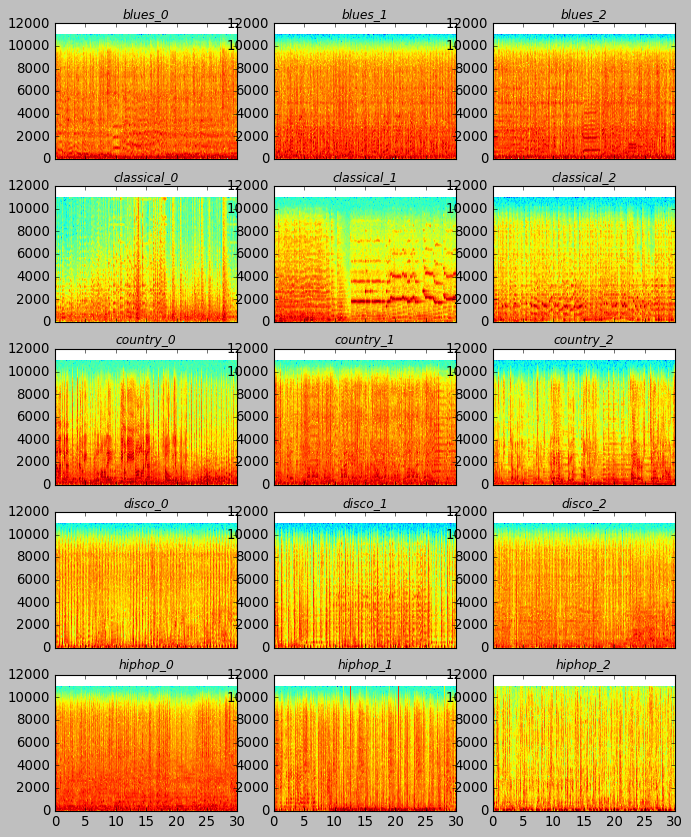

In [11]:
plt.style.use('classic')
f, ax = plt.subplots(5,3, sharex=True, sharey=False)
for i in range(5):  
    ls_path=pd.Series(all_file)[[int(z.find(str(genres[i])))>0 for z in all_file]].tolist()[3:6]
    for j in range(len(ls_path)):   
        sample_rate,song=wavfile.read(ls_path[j])
        ax[i,j].set_title(genres[i]+'_'+str(j),fontsize=11,fontstyle='italic')
        ax[i,j].specgram(song, Fs=sample_rate, xextent=(0,30))
        
f.set_figheight(12.3)
f.set_figwidth(10)   


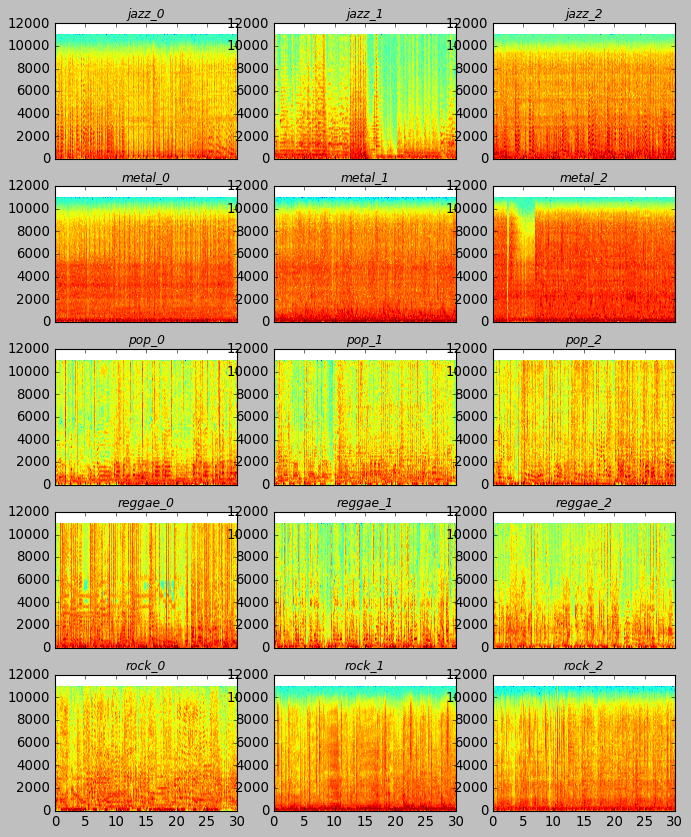

In [12]:
plt.style.use('classic')
f, ax = plt.subplots(5,3, sharex=True, sharey=False)
for i in range(5):  
    ls_path=pd.Series(all_file)[[int(z.find(str(genres[i+5])))>0 for z in all_file]].tolist()[3:6]
    for j in range(len(ls_path)):   
        sample_rate,song=wavfile.read(ls_path[j])
        ax[i,j].set_title(genres[i+5]+'_'+str(j),fontsize=11,fontstyle='italic')
        ax[i,j].specgram(song, Fs=sample_rate, xextent=(0,30))
        
f.set_figheight(12.3)
f.set_figwidth(10)   


## Section 1.6 - La TF sur un song <a class="anchor" id="section_1_6"></a>

In [11]:
sample_rate,song=wavfile.read(random_file())
DURATION=len(song)/sample_rate
N = len(song)

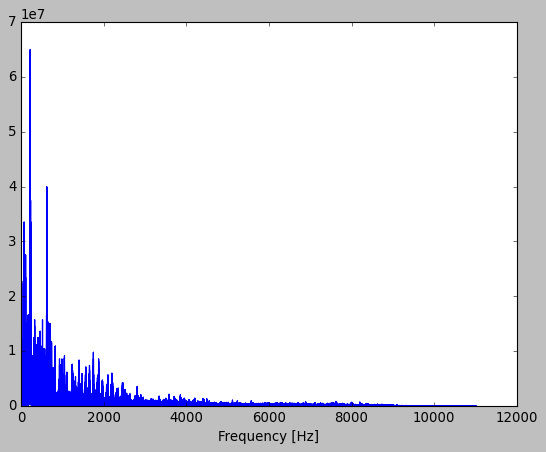

In [12]:
yf = fft(song)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(np.abs(xf), np.abs(yf))
plt.xlabel('Frequency [Hz]')
plt.show()

# Chap 2 : Classification sur deux classes <a class="anchor" id="chapter2"></a>
Avant de commencer la classification sur les 10 classes nous allons nous restreindre à deux classes uniquement et les classifier.
## Section 2.1 :  Chargement données <a class="anchor" id="section_2_1"></a>
On commence par charger les song blues et classical sur les quels on applique la fft en gardant les 1000 premiers coefficients

In [97]:
genre1=pd.Series(all_file)[[int(z.find('blues'))>0 for z in all_file]].tolist()
genre2=pd.Series(all_file)[[int(z.find('classical'))>0 for z in all_file]].tolist()
X=[]
Y=[]
for i,file in enumerate(genre1+genre2):
    label = file.split('/')[1]
    sample_rate,song=wavfile.read(file)
    fft_features = abs(fft(song)[:1000]) 
    X.append(fft_features)
    Y.append(label)
    
    if i % 50 ==0:
        print('Step : {}/{}'.format(i,len(genre1+genre2)))
    

Step : 0/200
Step : 50/200
Step : 100/200
Step : 150/200


On mélange nos données et on crée nos échantillon d'entrainement et de validation.

In [98]:
target=pd.Series(Y).map({'blues':0,'classical':1})
data=np.array(X)
random_indices = np.arange(data.shape[0])
random.shuffle(random_indices)
target = target[random_indices]
data = data[random_indices,:]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,stratify=target)
print("Echantillon d'entrainement (lignes,colonnes):",X_train.shape)
print("Echantillon de test (lignes,colonnes):",X_test.shape)
print(y_train.value_counts())

Echantillon d'entrainement (lignes,colonnes): (140, 1000)
Echantillon de test (lignes,colonnes): (60, 1000)
1    70
0    70
dtype: int64


In [99]:
X_train=(X_train-np.mean(X_train))/np.std(X_train)
y_train=(y_train-np.mean(y_train))/np.std(y_train)

## Section 2.2  : Présentation algo <a class="anchor" id="section_2_2"></a>
ci, nous sommes dans un cas de classification binaire, nous cherchons à différencier les genres "blues" et "classical". Pour cela nous allons utiliser plusieurs modèles afin de comparer les performances. Nous entrainons chaque modèle en utilisant de la validation croisée (5-fold cross validation par défaut). Pour comparer les performances de nos modèles, nous utilisons: accuracy = nombre de prédictions correctes / nombre de prédictions totales.

 

* **LogisticRegression :** L'idée est d'appliquer un modèle de régression logistique pour estimer une probabilité d'appartenir à l'une ou l'autre classe. La prédiction engendrée sera pour la classe considérée commme la plus probable (> 0.5). (source:https://fr.wikipedia.org/wiki/R%C3%A9gression_logistique)
* **SVC :** La SVM est un ensemble de méthodes d’apprentissage supervisées utilisées pour la classification et la régression. Les SVM peuvent être utilisés pour résoudre des problèmes de discrimination, c'est-à-dire décider à quelle classe appartient une observation. La marge est la distance entre la frontière de séparation et les observations les plus proches. Ces dernières sont appelées vecteurs supports. Dans les SVM, la frontière de séparation est choisie comme celle qui maximise la marge. On souhaite trouver une frontière séparatrice optimale, à partir d'un ensemble d'apprentissage en résolvant un problème d'optimisation quadratique. Dans le cas où les données ne sont pas linéairement séparables, on peut, à l'aide d'une fonction noyau, transformer l'espace de représentation des données d'entrées en un espace de plus grande dimension (possiblement de dimension infinie), dans lequel il est probable qu'il existe une séparation linéaire. (source: https://fr.wikipedia.org/wiki/Machine_%C3%A0_vecteurs_de_support) 
* **XGBClassifier :** Il s'agit d'une technique d'agrégation de modèles. Plutôt que d’utiliser un seul modèle, nous en utilisons plusieurs que nous agrégeons ensuite pour obtenir un seul résultat. Dans la construction des modèles, le Boosting travaille de manière séquentielle. Il commence par construire un premier modèle qu’il va évaluer. A partir de cette mesure, chaque individu va être pondéré en fonction de la performance de la prédiction. L’objectif est de donner un poids plus important aux individus pour lesquels la valeur a été mal prédite pour la construction du modèle suivant. Le fait de corriger les poids au fur et à mesure permet de mieux prédire les valeurs difficiles. Cet algorithme utilise le gradient de la fonction de perte pour le calcul des poids des individus lors de la construction de chaque nouveau modèle. (source : https://www.lovelyanalytics.com/2016/09/12/gradient-boosting-comment-ca-marche/)
* **LinearDiscriminantAnalysis :** C'est un algorithme de classification linéaire, comme la régression logistique. Cela signifie que les classes sont séparées dans l'espace des variables explicatives par des droites ou des hyperplans. Les prédictions sont effectuées en estimant la probabilité qu'une nouvelle observation appartienne à chacune des classes, en se basant sur les valeurs de chaques variables explicatives. La classe prédite correspond à la classe avec la plus haute probabilité d'appartenance. (source: https://machinelearningmastery.com/linear-discriminant-analysis-with-python/)
* **KNeighborsClassifier :** En reconnaissance de forme, l'algorithme des k plus proches voisins (k-NN) est une méthode non paramétrique utilisée pour la classification et la régression. Dans les deux cas, il s'agit de classer l'entrée dans la catégorie à laquelle appartient les k plus proches voisins dans l'espace des caractéristiques identifiées par apprentissage. En classification k-NN, le résultat est une classe d'appartenance. Un objet d'entrée est classifié selon le résultat majoritaire des statistiques de classes d'appartenance de ses k plus proches voisins, (k est un nombre entier positif généralement petit). (source: https://fr.wikipedia.org/wiki/M%C3%A9thode_des_k_plus_proches_voisins)
* **DecisionTreeClassifier :** Dans le cas des arbres de classification, il s'agit d'un problème de classification automatique. Le critère d’évaluation des partitions caractérise l'homogénéité (ou le gain en homogénéité) des sous-ensembles obtenus par division de l'ensemble. Ces métriques sont appliquées à chaque sous-ensemble candidat et les résultats sont combinés (par exemple, moyennés) pour produire une mesure de la qualité de la séparation. (source: https://fr.wikipedia.org/wiki/Arbre_de_d%C3%A9cision_(apprentissage)#Cas_des_arbres_de_classification)
* **GaussianNB :** La classification naïve bayésienne est un type de classification bayésienne probabiliste simple basée sur le théorème de Bayes avec une forte indépendance (dite naïve) des hypothèses. Elle met en œuvre un classifieur bayésien naïf, ou classifieur naïf de Bayes, appartenant à la famille des classifieurs linéaires. L'estimation des paramètres pour les modèles bayésiens naïfs repose sur le maximum de vraisemblance. Autrement dit, il est possible de travailler avec le modèle bayésien naïf sans se préoccuper de probabilité bayésienne ou utiliser les méthodes bayésiennes. Le classifieur associé consiste à choisir l'hypothèse la plus probable. Il s'agit de la règle du maximum a posteriori. (source: https://fr.wikipedia.org/wiki/Classification_na%C3%AFve_bay%C3%A9sienne)

In [3]:
def model_perf_cv(X_train,Y_train,scor='accuracy',CVAL=5,graph=True):
    plt.style.use('seaborn')
    
    
    models = [LogisticRegression(),SVC(kernel='rbf',C=9),XGBClassifier(),LinearDiscriminantAnalysis(),
             KNeighborsClassifier(), DecisionTreeClassifier(),GaussianNB()]
    didi={'LogisticRegression':'LogReg',
         'SVC':'SVM',
         'XGBClassifier':'XGB',
         'LinearDiscriminantAnalysis':'LDA',
         'KNeighborsClassifier':'KNN',
         'DecisionTreeClassifier':'CART',
         'GaussianNB':'NB'}
    
    name=['LogisticRegression','SVC','XGBClassifier','LinearDiscriminantAnalysis',
         'KNeighborsClassifier','DecisionTreeClassifier','GaussianNB']

    CV = CVAL
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    print('Metrics = {0}'.format(scor))
    z=0

    for model in models:

        model_name = name[z]
        z+=1
        cv_results = cross_val_score(model,X_train, Y_train, scoring=scor, cv=CV)
        msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
        print(msg)
        
        
        for fold_idx, accuracy in enumerate(cv_results):
            entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', '{0}'.format(scor)])
    if graph:
        cv_df['model_name']=cv_df['model_name'].map(didi)
        plt.figure(figsize=(12,8))
        sns.boxplot(x='model_name',y='{0}'.format(scor),data=cv_df)
        plt.show()
    return cv_df.groupby('model_name').mean()[['accuracy']]

def model_perf_test(X_train,Y_train,X_test,Y_test,scor):
    
    models =[LogisticRegression(),SVC(),XGBClassifier(),LinearDiscriminantAnalysis(),
             KNeighborsClassifier(), DecisionTreeClassifier(),GaussianNB()]


    
    print('Metrics = {0}'.format(scor.__name__))
    ZZZ=[]
    for model in models:

        model_name = model.__class__.__name__
        model.fit(X_train,Y_train)
        pred=model.predict(X_test)
        print(model_name+" : "+str(scor(Y_test,pred)))
              
        ZZZ.append(scor(Y_test,pred))
    return ZZZ
    
        

## Section 2.3  : Optimisation svm <a class="anchor" id="section_2_3"></a>
#### Le choix du noyau
article : https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c


"Les machines à vecteurs de support fonctionnent en trouvant des points de données de différentes classes et en dessinant des limites entre eux. Si les données d'entrée sont linéairement séparables, la résolution de l'hyperplan est simple. Mais il arrive souvent que les régions de classification se chevauchent et qu’aucun plan rectiligne ne puisse servir de frontière."


"Une façon de contourner ce problème consiste à projeter vos données dans des dimensions plus élevées en créant des fonctionnalités supplémentaires. Au lieu de l'espace bidimensionnel que vous obtenez en ayant les caractéristiques a et b, vous pouvez les combiner (par exemple ab, a², b²) et essayer de trouver des motifs (ou un hyperplan diviseur) dans ces dimensions."


"Mais il y a un problème avec cette approche. Bien que les dimensions supplémentaires facilitent la recherche d'un hyperplan, cela donne également à votre algorithme plus de fonctionnalités à apprendre.
Les SVM nous permettent de contourner cet apprentissage supplémentaire en utilisant le Kernel Trick."

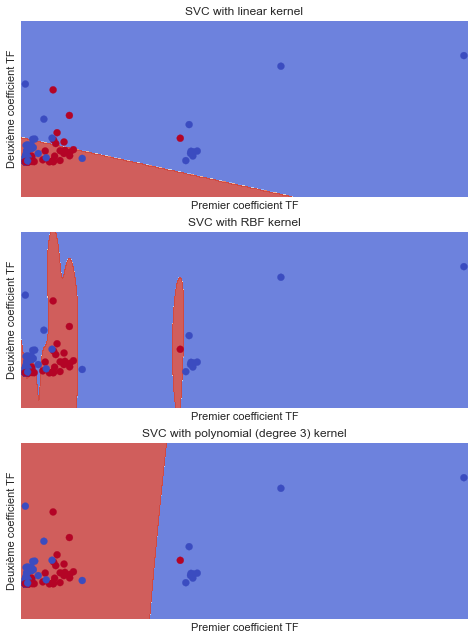

In [64]:
plt.style.use('seaborn')
h = .02  # step size in the mesh
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = SVC(kernel='linear', C=C).fit(X_train[:,0:2], y_train)
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train[:,0:2], y_train)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X_train[:,0:2], y_train)

# create a mesh to plot in
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

f, ax = plt.subplots(3, sharex=True, sharey=False)

for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax[i].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    ax[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train.values, cmap=plt.cm.coolwarm)
    ax[i].set_xlabel('Premier coefficient TF')
    ax[i].set_ylabel('Deuxième coefficient TF')
    ax[i].set_xlim(xx.min(), xx.max())
    ax[i].set_ylim(yy.min(), yy.max())
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(titles[i])
f.set_figheight(11)
f.set_figwidth(8)   
plt.show()

Même si il n'est pas pertinent d'utiliser uniquement deux coefficient de la transformé de fourier. Cette simplification permet de représenter notre problème en deux dimension en ainsi observer les frontière de décision en fonction de différents noyau pris par le SVM. On voit clairement que le noyau a un impact énorme sur la grontière de décision, implact qu'on doit retrouver quand on repasse en dimension 1000. Ici il est difficile de dégager un noyau meilleur que les autres graphiquement. Dans la prochaine étape nous allons sélectionner le meilleur noyau par cross validation. 

In [72]:
parameters = {'kernel':('linear', 'rbf','poly')}
svr = SVC()
grid = GridSearchCV(SVC(),parameters)
grid.fit(X_train,y_train)
grid.cv_results_

{'mean_fit_time': array([0.01318016, 0.01229062, 0.01301117]),
 'std_fit_time': array([0.00135965, 0.00065619, 0.00047038]),
 'mean_score_time': array([0.00309653, 0.00294328, 0.00293827]),
 'std_score_time': array([6.73300339e-04, 1.98173833e-04, 3.78417680e-05]),
 'param_kernel': masked_array(data=['linear', 'rbf', 'poly'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 'linear'}, {'kernel': 'rbf'}, {'kernel': 'poly'}],
 'split0_test_score': array([0.89285714, 0.71428571, 0.67857143]),
 'split1_test_score': array([0.85714286, 0.78571429, 0.67857143]),
 'split2_test_score': array([0.85714286, 0.85714286, 0.78571429]),
 'split3_test_score': array([0.60714286, 0.67857143, 0.53571429]),
 'split4_test_score': array([0.89285714, 0.82142857, 0.75      ]),
 'mean_test_score': array([0.82142857, 0.77142857, 0.68571429]),
 'std_test_score': array([0.10832679, 0.06624013, 0.08571429]),
 'rank_test_score': array([1, 2, 3], dty

On voit que sur l'échantillon d'entrainement c'est le noyau linéaire qui fournit les meilleur résultat. 

#### The Penalty Parameter


"Que fait le paramètre C dans la classification SVM? Il indique à l'algorithme à quel point vous vous souciez des points mal classés.
Les SVM, en général, cherchent à trouver l'hyperplan à marge maximale. Autrement dit, la ligne qui a autant de place des deux côtés que possible.
Une valeur élevée pour C indique à l'algorithme que vous vous souciez plus de classer correctement tous les points d'entraînement que de laisser une marge de manœuvre pour les données futures.
Pensez-y comme ceci: si vous augmentez le paramètre C, vous pariez que les données d'entraînement contiennent les observations les plus extrêmes possibles. Vous pariez que les futures observations seront plus éloignées des limites que les points sur lesquels vous avez entraîné le modèle."

Intuitivement on dira qu'augementer c augmente le risque de sur-apprentissage

Voyons comment la modification du paramètre C peut influencer nos modèles.

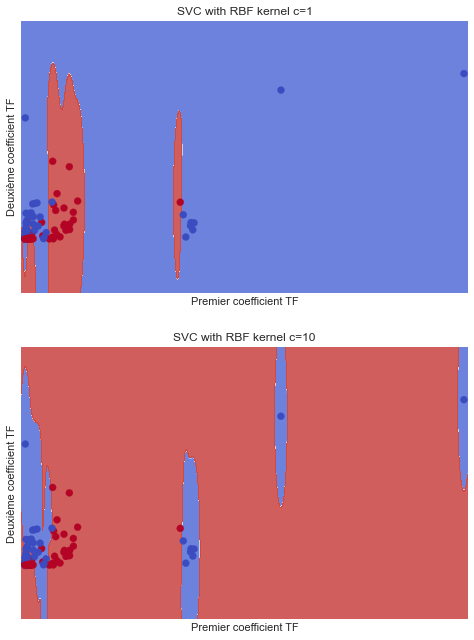

In [106]:
plt.style.use('seaborn')
h = .02  # step size in the mesh
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = SVC(kernel='rbf',gamma=0.7 ,C=1.0).fit(X_train[:,0:2], y_train)
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=10.0).fit(X_train[:,0:2], y_train)

# create a mesh to plot in
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with RBF kernel c=1',
          'SVC with RBF kernel c=10']

f, ax = plt.subplots(2, sharex=True, sharey=False)

for i, clf in enumerate((svc, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax[i].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    ax[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train.values, cmap=plt.cm.coolwarm)
    ax[i].set_xlabel('Premier coefficient TF')
    ax[i].set_ylabel('Deuxième coefficient TF')
    ax[i].set_xlim(xx.min(), xx.max())
    ax[i].set_ylim(yy.min(), yy.max())
    ax[i].set_xticks(())
    ax[i].set_yticks(())
    ax[i].set_title(titles[i])
f.set_figheight(11)
f.set_figwidth(8)   
plt.show()

On a volontairement mis une importante valeur du paramètre de pénalité pour mettre en avant l'impact de cette contrainte. On voit en effet que quand c=10 le classifieur crée deux nouvelles régions de classification à droite pour correctement classifier deux points uniquement. On a donc un important overfit dans le cas ou c=10.

In [128]:
parameters = {'kernel':('linear', 'rbf','poly'),'C':np.arange(1,10,1)}
svr = SVC()
grid = GridSearchCV(SVC(),parameters)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'kernel': ('linear', 'rbf', 'poly')})

In [131]:
print('Meilleur paramètre pour c trouvé par cross validation :',grid.best_params_['C'])
print('Meilleur noyau en fonction du c trouvé par cross validation :',grid.best_params_['kernel'])

Meilleur paramètre pour c trouvé par cross validation : 9
Meilleur noyau en fonction du c trouvé par cross validation : rbf


On voit que même si graphiquement on pensait avoir de l'overfit, quand on a joute l'ensemble de l'échantillon la cross validation trouve une nouvelle combinaison. On prendra ces paramètres pour le svm dans les prochaines étapes

## Section 2.4 :  Résultats sur les coéfficients de fourier <a class="anchor" id="section_2_4"></a>
On va maintenant utiliser les différents classifieurs présentés plus haut.


On utilise la fonction model_perf_cv pour calculer le score de cross validation sur l'échantillon d'entrainement et visualiser les résultats grace au boxplot.

On utilise ensuite la fonction model_perf_test pour connaitre les résultats sur l'échantillon de test

In [135]:
target=pd.Series(Y).map({'blues':0,'classical':1})
data=np.array(X)
random_indices = np.arange(data.shape[0])
random.shuffle(random_indices)
target = target[random_indices]
data = data[random_indices,:]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,stratify=target)
print("Echantillon d'entrainement (lignes,colonnes):",X_train.shape)
print("Echantillon de test (lignes,colonnes):",X_test.shape)
print(y_train.value_counts())

Echantillon d'entrainement (lignes,colonnes): (140, 1000)
Echantillon de test (lignes,colonnes): (60, 1000)
1    70
0    70
dtype: int64


Metrics = accuracy
LogisticRegression: 0.835714 (0.073540)
SVC: 0.814286 (0.041650)
XGBClassifier: 0.878571 (0.036422)
LinearDiscriminantAnalysis: 0.721429 (0.052489)
KNeighborsClassifier: 0.814286 (0.014286)
DecisionTreeClassifier: 0.800000 (0.066240)
GaussianNB: 0.728571 (0.042857)


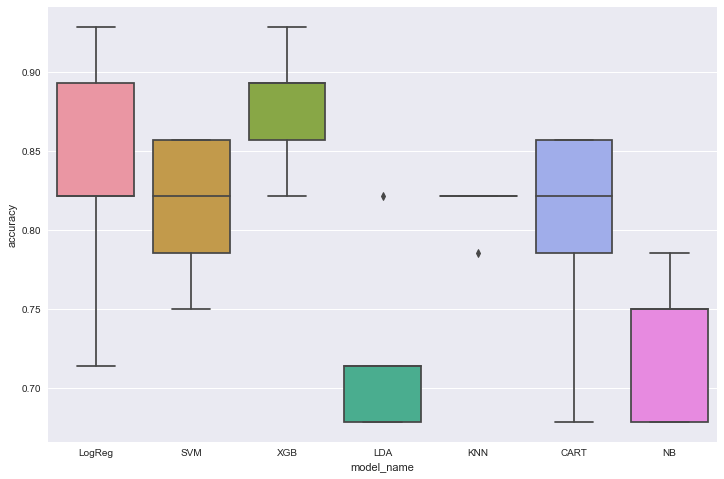

In [140]:
cv_df=model_perf_cv(X_train,y_train,scor='accuracy',CVAL=5)

In [141]:
test1=model_perf_test(X_train,y_train,X_test,y_test,accuracy_score)

Metrics = accuracy_score
LogisticRegression : 0.9
SVC : 0.8166666666666667
XGBClassifier : 0.8666666666666667
LinearDiscriminantAnalysis : 0.7666666666666667
KNeighborsClassifier : 0.8666666666666667
DecisionTreeClassifier : 0.8
GaussianNB : 0.7333333333333333


## Section 2.5 :  Présentation des métriques <a class="anchor" id="section_2_5"></a>

 La courbe de ROC est une courbe qui permet de mesurer de la performance d'un classificateur binaire.
Graphiquement, c'est une courbe donne le taux de vrais positifs en fonction du taux de faux positifs.

 

-TP (true positives) : les prédits positifs qui le sont vraiment.
-FP (false positives) : les prédits positifs qui sont en fait négatifs.
-TN (true negatives) : les prédits négatifs qui le sont vraiment.
-FN (false negatives) : les prédits négatifs qui sont en fait positifs.

 

TVP : est la proportion des positifs qui sont effectivement détectés par le modèle.
$$TPF=\frac{VP}{VP+FP}$$

 

TFP : est la proportion des négatifs qui sont mal détectés par le modèle.
$$TFP=\frac{FN}{VN+FN}$$



In [18]:
Log_reg=LogisticRegression()
Log_reg.fit(X_train,y_train)
prd=Log_reg.predict(X_test)

In [19]:
dd=confusion_matrix(y_test,prd)
df=pd.DataFrame(dd,columns=['Predicted classe 1','Predicted classe 2'],
             index=['Actual classe 1',' Actual classe 2'])
df

,Predicted classe 1,Predicted classe 2
Actual classe 1,25,5
Actual classe 2,4,26


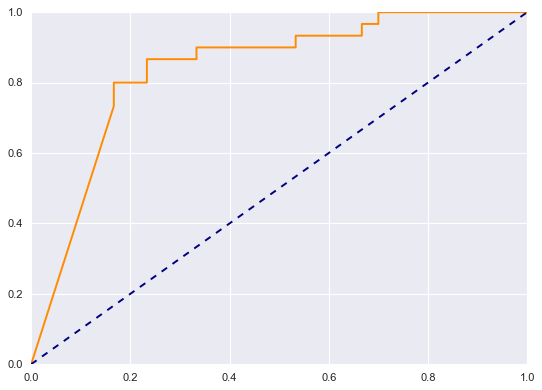

In [49]:
proba=Log_reg.predict_proba(X_test)
fpr, tpr, _=roc_curve(y_test, proba[:,1])
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy' ,linestyle='--')

## Section 2.6 :  Résultats avec le mfcc <a class="anchor" id="section_2_6"></a>

article utilisé : http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


Le cepstrum mel-frequency (MFC) est une représentation du spectre de puissance à court terme d’un son, basé sur une transformation linéaire
du spectre de puissance sur une échelle de mel.


Mel Frequency Cepstral Coefficient (MFCC) : sont des coefficients cepstraux calculés par une transformée en cosinus discrète appliquée
au spectre de puissance d'un signal.


Le cepstre d'un signal $x(t)$ est une transformation de ce signal du domaine temporel vers un autre domaine analogue au domaine temporel.
 

L'utilité d'une telle déformation de fréquence est de permettre une meilleure réprésentation du son.



Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition : 

* 1. On sépare le signal en courte frame : Un signal audio change constamment, donc pour simplifier les choses, nous supposons que sur des échelles de temps courtes, le signal audio ne change pas beaucoup. C'est pourquoi nous encadrons le signal dans des frames très courtes.
* 2. L'étape suivante consiste à calculer le spectre de puissance de chaque frame. On identifie les fréquences présentes dans la frame.
* 3. On applique "the mel filterbank" 
* 4. Prenez le logarithme de toutes les énergies "filterbank".
* 5. Prenez le DCT des énergies du log filterbank energies.

In [43]:
genre1=pd.Series(all_file)[[int(z.find('blues'))>0 for z in all_file]].tolist()
genre2=pd.Series(all_file)[[int(z.find('classical'))>0 for z in all_file]].tolist()
X=[]
Y=[]
for i,file in enumerate(genre1+genre2):
    label = file.split('/')[1]
    
    sample_rate,song=wavfile.read(file)
    mfcc_feat = mfcc(signal=song,
                     samplerate=sample_rate)
                    #winlen=0.025,  #the length of the analysis window in second
                    #winstep=0.01, #the step between successive windows in seconds.
                    #numcep=13, #the number of cepstrum to return
                    #nfft=551) #the FFT size
    
    num_ceps=13
    
    #Taking all of the data would overwhelm our classifier. What we could do instead is to do an averaging
    # per coefficient over all the frames. 
    # Assuming that the start and end of each song are possibly 
    # less genre-specific than the middle part of it, we also ignore the first and last 10 percent:
    x = np.mean(mfcc_feat[int(num_ceps*1/10):int(num_ceps*9/10)], axis=0) 
    X.append(x)
    Y.append(label)    
    if i % 50 ==0:
        print('Step : {}/{}'.format(i,len(genre1+genre2)))
        
    if i==199:
        print('\n')
        print('Nombre de frames  : {}'.format(mfcc_feat.shape[0]))

Step : 0/200


Step : 50/200


Step : 100/200


Step : 150/200




Nombre de frames  : 2994


In [44]:
target=pd.Series(Y).map({'blues':0,'classical':1})
data=np.array(X)
random_indices = np.arange(data.shape[0])
random.shuffle(random_indices)
target = target[random_indices]
data = data[random_indices,:]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,stratify=target)
print(X_train.shape)
print(X_test.shape)

(140, 13)
(60, 13)


Metrics = accuracy
LogisticRegression: 0.878571 (0.042857)
SVC: 0.857143 (0.050508)
XGBClassifier: 0.871429 (0.036422)
LinearDiscriminantAnalysis: 0.878571 (0.028571)
KNeighborsClassifier: 0.771429 (0.042857)
DecisionTreeClassifier: 0.764286 (0.042857)
GaussianNB: 0.857143 (0.039123)


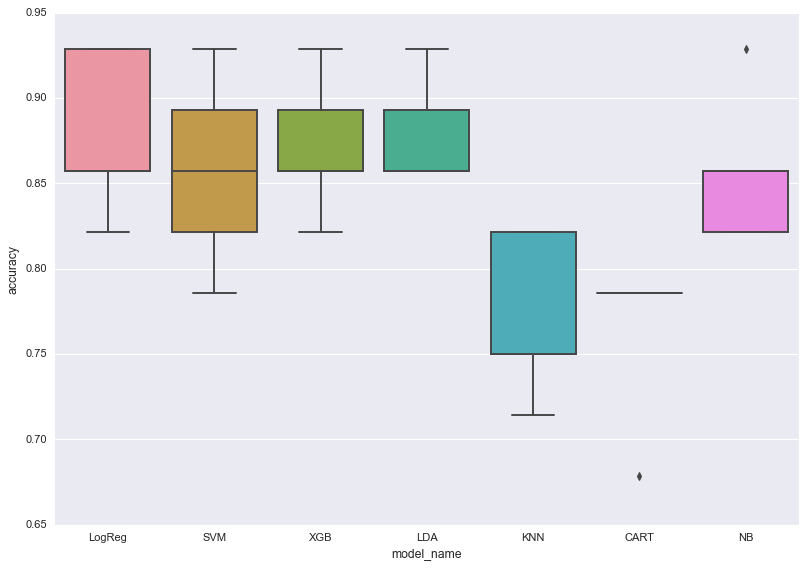

In [46]:
#import warnings
#warnings.filterwarnings("ignore")
t=model_perf_cv(X_train,y_train)

In [47]:
test2=model_perf_test(X_train,y_train,X_test,y_test,accuracy_score)

Metrics = accuracy_score
LogisticRegression : 0.9166666666666666
SVC : 0.85
XGBClassifier : 0.9
LinearDiscriminantAnalysis : 0.9166666666666666
KNeighborsClassifier : 0.7833333333333333
DecisionTreeClassifier : 0.9
GaussianNB : 0.9


## Section 2.7 :  Comparer les résultats <a class="anchor" id="section_2_6"></a>

In [48]:
pd.DataFrame([test1,test2],index=['fft','mfcc'],columns=['LogisticRegression','SVC','XGBClassifier',
             'LinearDiscriminantAnalysis','KNeighborsClassifier','DecisionTreeClassifier',
         'GaussianNB'])

,LogisticRegression,SVC,XGBClassifier,LinearDiscriminantAnalysis,KNeighborsClassifier,DecisionTreeClassifier,GaussianNB
fft,0.850000,0.783333,0.833333,0.633333,0.883333,0.8,0.733333
mfcc,0.916667,0.850000,0.900000,0.916667,0.783333,0.9,0.900000


On observe que les résultats sont généralement meilleurs pour le mfcc. 

# Chapter 3 Classification sur les 10 classes <a class="anchor" id="chapter3"></a>
## Section 3.1 Choisir le nombre de fréquences optimal.  <a class="anchor" id="section_3_1"></a>

Nous allons pour choisir ce nombre :
* 1. Sélectionner un petit échantillon du train pour accélerer l'entrainement (20musiques par classe)
* 2. Sur ce petit échantillon calculer pour chaque $m \in \{500,1000,...,4500\}$ le score avec 5-kfold des différents algorithmes présentés plus haut. 

In [4]:
def select_stratify_sample(all_file,target_size):
    all_file_2=[]
    for i in range(0,1000,100):
        all_file_2+=all_file[i:i+target_size]
    return all_file_2

In [7]:
# On commence par sélectionner 20 musiques par classe
all_file_2=select_stratify_sample(all_file,20)
print("Data shape : ",len(all_file_2))

Data shape :  200


In [16]:
cv_df_ls=[]
for m in list(range(500,5000,500)):
    print('m first fft features =',m)
    X=[]
    Y=[]
    for i,file in enumerate(all_file_2):
        label = file.split('/')[1]
        sample_rate,song=wavfile.read(file)
        fft_features = abs(fft(song)[:m]) 
        X.append(fft_features)
        Y.append(label)
        
    print('\n')
            
    target=pd.Series(Y).map({'blues':0,'classical':1,'country':2,
                     'disco':3,'hiphop':4,'jazz':5,'metal':6,
                    'pop':7,'reggae':8,'rock':9})
    data=np.array(X)
    random_indices = np.arange(data.shape[0])
    random.shuffle(random_indices)
    target = target[random_indices]
    data = data[random_indices,:]
    cv_df=model_perf_cv(data,target,scor='accuracy',CVAL=5,graph=False)
    cv_df_ls.append(cv_df)
    print('\n')

    
        


m first fft features = 500


Metrics = accuracy
LogisticRegression: 0.250000 (0.047434)
SVC: 0.310000 (0.064420)
XGBClassifier: 0.340000 (0.033912)
LinearDiscriminantAnalysis: 0.205000 (0.036742)
KNeighborsClassifier: 0.350000 (0.052440)
DecisionTreeClassifier: 0.225000 (0.044721)
GaussianNB: 0.235000 (0.064420)


m first fft features = 1000


Metrics = accuracy
LogisticRegression: 0.290000 (0.025495)
SVC: 0.315000 (0.064420)
XGBClassifier: 0.380000 (0.040000)
LinearDiscriminantAnalysis: 0.260000 (0.040620)
KNeighborsClassifier: 0.315000 (0.058310)
DecisionTreeClassifier: 0.280000 (0.082765)
GaussianNB: 0.245000 (0.069642)


m first fft features = 1500


Metrics = accuracy
LogisticRegression: 0.260000 (0.087464)
SVC: 0.385000 (0.112472)
XGBClassifier: 0.305000 (0.024495)
LinearDiscriminantAnalysis: 0.250000 (0.041833)
KNeighborsClassifier: 0.280000 (0.029155)
DecisionTreeClassifier: 0.235000 (0.051478)
GaussianNB: 0.310000 (0.091652)


m first fft features = 2000


Metrics = accuracy
L

In [26]:
odd=pd.concat(cv_df_ls,axis=1)
columns_name=["Acc_m_{}".format(j) for i,j in enumerate(list(range(500,5000,500)))]
odd.columns=columns_name
odd

,Acc_m_500,Acc_m_1000,Acc_m_1500,Acc_m_2000,Acc_m_2500,Acc_m_3000,Acc_m_3500,Acc_m_4000,Acc_m_4500
model_name,,,,,,,,,
DecisionTreeClassifier,0.225,0.280,0.235,0.240,0.230,0.335,0.245,0.215,0.250
GaussianNB,0.235,0.245,0.310,0.370,0.335,0.365,0.385,0.400,0.365
KNeighborsClassifier,0.350,0.315,0.280,0.235,0.285,0.315,0.320,0.280,0.305
LinearDiscriminantAnalysis,0.205,0.260,0.250,0.240,0.260,0.255,0.325,0.255,0.325
LogisticRegression,0.250,0.290,0.260,0.310,0.280,0.285,0.320,0.290,0.285
SVC,0.310,0.315,0.385,0.370,0.400,0.485,0.490,0.460,0.465
XGBClassifier,0.340,0.380,0.305,0.335,0.320,0.360,0.330,0.345,0.330


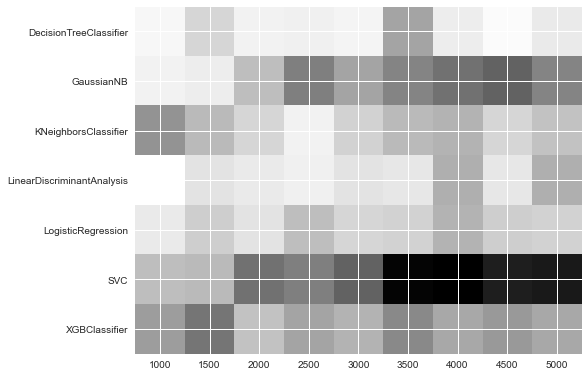

In [51]:
f, ax1 = plt.subplots(1, sharex=True, sharey=False)
ax1.imshow(odd)
ax1.set_xticklabels(list(range(500,5500,500)))
ax1.set_yticklabels([' ']+odd.index.tolist())
f.set_figheight(11)
f.set_figwidth(8)   
plt.show()

On observe que le SVC qu'on avait hyperparamétré obtient les meilleurs résultats parmis l'ensemble des algorithmes utilisés. On voit qu'augmenter le nombre de coéfficient de la transformée de fourier permet pas toujours d'augmenter le score d'accuracy (calculé sur les 20x10 =200 songs de notre échantillon). Néanmoins le score pour le svc semble beaucoup augmenter quand on augmente le nombre de coefficients de fouriers. On prendra donc 3500 coefficient pour la suite de l'analyse

## Section 3.2 the number of cepstrum to return.  <a class="anchor" id="section_3_2"></a>

In [60]:
cv_df_ls=[]
for ncep in list(range(9,29,2)):    
    print('m first mfcc features =',ncep)
    X=[]
    Y=[]
    for i,file in enumerate(all_file_2):
        label = file.split('/')[1]
        sample_rate,song=wavfile.read(file)
        mfcc_feat = mfcc(signal=song,
                     samplerate=sample_rate,
                        numcep=ncep)
        
        x = np.mean(mfcc_feat[int(ncep*1/10):int(ncep*9/10)], axis=0) 
        

        X.append(x)
        Y.append(label)
        
    print('\n')
            
    target=pd.Series(Y).map({'blues':0,'classical':1,'country':2,
                     'disco':3,'hiphop':4,'jazz':5,'metal':6,
                    'pop':7,'reggae':8,'rock':9})
    data=np.array(X)
    random_indices = np.arange(data.shape[0])
    random.shuffle(random_indices)
    target = target[random_indices]
    data = data[random_indices,:]
    cv_df=model_perf_cv(data,target,scor='accuracy',CVAL=5,graph=False)
    cv_df_ls.append(cv_df)
    print('\n')


m first mfcc features = 9




Metrics = accuracy
LogisticRegression: 0.345000 (0.060000)
SVC: 0.350000 (0.041833)


XGBClassifier: 0.335000 (0.078422)
LinearDiscriminantAnalysis: 0.390000 (0.037417)
KNeighborsClassifier: 0.325000 (0.054772)
DecisionTreeClassifier: 0.230000 (0.053385)
GaussianNB: 0.390000 (0.060415)


m first mfcc features = 11




Metrics = accuracy
LogisticRegression: 0.395000 (0.062048)
SVC: 0.370000 (0.055678)


XGBClassifier: 0.390000 (0.046368)
LinearDiscriminantAnalysis: 0.420000 (0.069642)
KNeighborsClassifier: 0.350000 (0.108397)
DecisionTreeClassifier: 0.215000 (0.025495)
GaussianNB: 0.390000 (0.064420)


m first mfcc features = 13




Metrics = accuracy
LogisticRegression: 0.365000 (0.051478)
SVC: 0.385000 (0.112472)


XGBClassifier: 0.305000 (0.036742)
LinearDiscriminantAnalysis: 0.385000 (0.081548)
KNeighborsClassifier: 0.355000 (0.055678)
DecisionTreeClassifier: 0.220000 (0.069642)
GaussianNB: 0.370000 (0.040000)


m first mfcc features = 15




Metrics = accuracy
LogisticRegression: 0.395000 (0.018708)
SVC: 0.405000 (0.043012)


XGBClassifier: 0.380000 (0.069642)
LinearDiscriminantAnalysis: 0.455000 (0.111131)
KNeighborsClassifier: 0.385000 (0.025495)
DecisionTreeClassifier: 0.195000 (0.067823)
GaussianNB: 0.420000 (0.062048)


m first mfcc features = 17




Metrics = accuracy
LogisticRegression: 0.395000 (0.065955)
SVC: 0.440000 (0.098234)


XGBClassifier: 0.355000 (0.101735)
LinearDiscriminantAnalysis: 0.480000 (0.053385)
KNeighborsClassifier: 0.315000 (0.056125)
DecisionTreeClassifier: 0.205000 (0.069642)
GaussianNB: 0.405000 (0.078102)


m first mfcc features = 19




Metrics = accuracy
LogisticRegression: 0.370000 (0.096695)
SVC: 0.450000 (0.103682)


XGBClassifier: 0.325000 (0.075829)
LinearDiscriminantAnalysis: 0.460000 (0.051478)
KNeighborsClassifier: 0.380000 (0.067823)
DecisionTreeClassifier: 0.240000 (0.020000)
GaussianNB: 0.475000 (0.041833)


m first mfcc features = 21




Metrics = accuracy
LogisticRegression: 0.395000 (0.096695)
SVC: 0.400000 (0.070711)


XGBClassifier: 0.320000 (0.060000)
LinearDiscriminantAnalysis: 0.460000 (0.046368)
KNeighborsClassifier: 0.355000 (0.057879)
DecisionTreeClassifier: 0.200000 (0.093541)
GaussianNB: 0.405000 (0.073144)


m first mfcc features = 23




Metrics = accuracy
LogisticRegression: 0.385000 (0.043589)
SVC: 0.430000 (0.029155)


XGBClassifier: 0.355000 (0.029155)
LinearDiscriminantAnalysis: 0.445000 (0.033166)
KNeighborsClassifier: 0.410000 (0.033912)
DecisionTreeClassifier: 0.230000 (0.095394)
GaussianNB: 0.440000 (0.058310)


m first mfcc features = 25




Metrics = accuracy
LogisticRegression: 0.395000 (0.024495)
SVC: 0.450000 (0.082158)


XGBClassifier: 0.310000 (0.121037)
LinearDiscriminantAnalysis: 0.415000 (0.048990)
KNeighborsClassifier: 0.350000 (0.089443)
DecisionTreeClassifier: 0.190000 (0.060415)
GaussianNB: 0.385000 (0.060415)


m first mfcc features = 27




Metrics = accuracy
LogisticRegression: 0.390000 (0.053852)
SVC: 0.425000 (0.068920)
XGBClassifier: 0.325000 (0.088034)
LinearDiscriminantAnalysis: 0.415000 (0.064420)
KNeighborsClassifier: 0.350000 (0.057009)
DecisionTreeClassifier: 0.250000 (0.079057)
GaussianNB: 0.400000 (0.119373)




In [64]:
odd=pd.concat(cv_df_ls,axis=1)
columns_name=["Acc_mfc_{}".format(j) for i,j in enumerate(list(range(9,29,2)))]
odd.columns=columns_name
odd

,Acc_mfc_9,Acc_mfc_11,Acc_mfc_13,Acc_mfc_15,Acc_mfc_17,Acc_mfc_19,Acc_mfc_21,Acc_mfc_23,Acc_mfc_25,Acc_mfc_27
model_name,,,,,,,,,,
DecisionTreeClassifier,0.230,0.215,0.220,0.195,0.205,0.240,0.200,0.230,0.190,0.250
GaussianNB,0.390,0.390,0.370,0.420,0.405,0.475,0.405,0.440,0.385,0.400
KNeighborsClassifier,0.325,0.350,0.355,0.385,0.315,0.380,0.355,0.410,0.350,0.350
LinearDiscriminantAnalysis,0.390,0.420,0.385,0.455,0.480,0.460,0.460,0.445,0.415,0.415
LogisticRegression,0.345,0.395,0.365,0.395,0.395,0.370,0.395,0.385,0.395,0.390
SVC,0.350,0.370,0.385,0.405,0.440,0.450,0.400,0.430,0.450,0.425
XGBClassifier,0.335,0.390,0.305,0.380,0.355,0.325,0.320,0.355,0.310,0.325


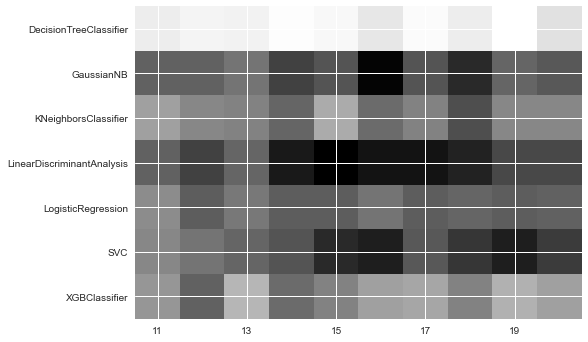

In [78]:
f, ax1 = plt.subplots(1, sharex=True, sharey=False)
ax1.imshow(odd)
ax1.set_xticklabels(list(range(9,29,2)))
ax1.set_yticklabels([' ']+odd.index.tolist())
f.set_figheight(11)
f.set_figwidth(8)   
plt.show()

Encore une fois augmneter le nombre de coefficient jusqu'à 19 permet d'obtenir un bon score avec le SVC. 

## Section 3.3 Comparer les résultats  <a class="anchor" id="section_3_3"></a>

#### Mfcc results

In [79]:
num_ceps=19
X=[]
Y=[]
for i,file in enumerate(all_file):
    label = file.split('/')[1]
    
    sample_rate,song=wavfile.read(file)
    mfcc_feat = mfcc(signal=song,
                     samplerate=sample_rate, #the step between successive windows in seconds.
                    numcep=num_ceps) #the number of cepstrum to return
    

    
    #Taking all of the data would overwhelm our classifier. What we could do instead is to do an averaging
    # per coefficient over all the frames. 
    # Assuming that the start and end of each song are possibly 
    # less genre-specific than the middle part of it, we also ignore the first and last 10 percent:
    x = np.mean(mfcc_feat[int(num_ceps*1/10):int(num_ceps*9/10)], axis=0) 
    X.append(x)
    Y.append(label)    
    if i % 200 ==0:
        print('Step : {}/{}'.format(i,len(all_file)))
        


Step : 0/1000


Step : 200/1000


Step : 400/1000


Step : 600/1000


Step : 800/1000


Metrics = accuracy
LogisticRegression: 0.351429 (0.035109)
SVC: 0.361429 (0.035743)
XGBClassifier: 0.350000 (0.035283)
LinearDiscriminantAnalysis: 0.372857 (0.022315)
KNeighborsClassifier: 0.342857 (0.034405)
DecisionTreeClassifier: 0.242857 (0.032888)
GaussianNB: 0.377143 (0.042234)


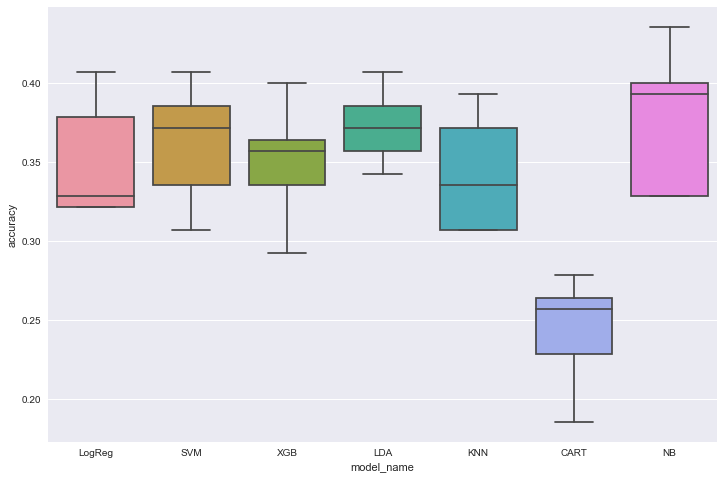

In [82]:
target=pd.Series(Y).map({'blues':0,'classical':1,'country':2,
                     'disco':3,'hiphop':4,'jazz':5,'metal':6,
                    'pop':7,'reggae':8,'rock':9})
data=np.array(X)
random_indices = np.arange(data.shape[0])
random.shuffle(random_indices)
target = target[random_indices]
data = data[random_indices,:]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,stratify=target)
cv_df=model_perf_cv(X_train,y_train,scor='accuracy',CVAL=5,graph=True)


In [83]:
test3=model_perf_test(X_train,y_train,X_test,y_test,accuracy_score)

Metrics = accuracy_score
LogisticRegression : 0.39
SVC : 0.3933333333333333
XGBClassifier : 0.39666666666666667
LinearDiscriminantAnalysis : 0.37666666666666665
KNeighborsClassifier : 0.38
DecisionTreeClassifier : 0.26666666666666666
GaussianNB : 0.37333333333333335


On voit que les résultats sont bien moins bon quand on utilise les 10 classes, car la complexité du problème a beaucoup augmenté. On constate qu'avec notre méthode de sélection du nombre de mfcc coefficient on obtient un score maximal avec le SVC de 0.39

#### TF results

In [98]:
num_fft=3500
X=[]
Y=[]
for i,file in enumerate(all_file):
    label = file.split('/')[1]
    sample_rate,song=wavfile.read(file)
    fft_features = abs(fft(song)[:num_fft]) 
    
    X.append(fft_features)
    Y.append(label)
    if i % 200 ==0:
        print('Step : {}/{}'.format(i,len(all_file)))
        


Step : 0/1000
Step : 200/1000
Step : 400/1000
Step : 600/1000
Step : 800/1000


Metrics = accuracy
LogisticRegression: 0.302857 (0.017261)
SVC: 0.437143 (0.015253)
XGBClassifier: 0.424286 (0.037143)
LinearDiscriminantAnalysis: 0.150000 (0.024328)
KNeighborsClassifier: 0.330000 (0.043425)
DecisionTreeClassifier: 0.262857 (0.017143)
GaussianNB: 0.341429 (0.027627)


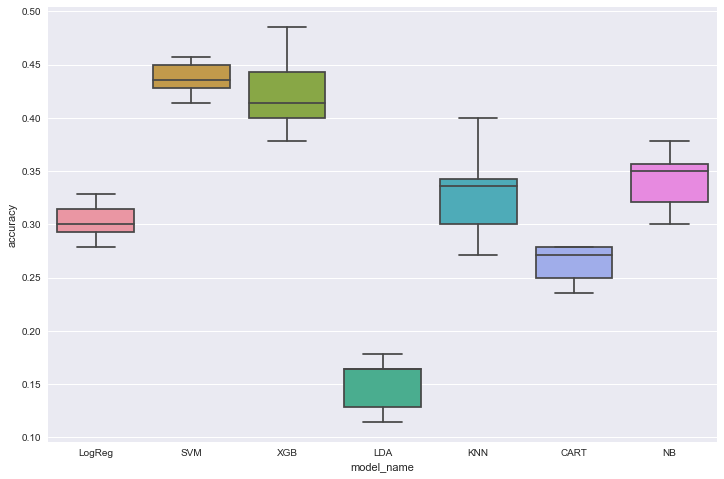

In [99]:
target=pd.Series(Y).map({'blues':0,'classical':1,'country':2,
                     'disco':3,'hiphop':4,'jazz':5,'metal':6,
                    'pop':7,'reggae':8,'rock':9})
data=np.array(X)
random_indices = np.arange(data.shape[0])
random.shuffle(random_indices)
target = target[random_indices]
data = data[random_indices,:]
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3,stratify=target)
cv_df=model_perf_cv(X_train,y_train,scor='accuracy',CVAL=5,graph=True)

In [100]:
test4=model_perf_test(X_train,y_train,X_test,y_test,accuracy_score)

Metrics = accuracy_score
LogisticRegression : 0.31
SVC : 0.44666666666666666
XGBClassifier : 0.48333333333333334
LinearDiscriminantAnalysis : 0.11333333333333333
KNeighborsClassifier : 0.3233333333333333
DecisionTreeClassifier : 0.30666666666666664
GaussianNB : 0.33


In [102]:
pd.DataFrame([test3,test4],index=['mfcc','fft'],columns=['LogisticRegression','SVC','XGBClassifier',
             'LinearDiscriminantAnalysis','KNeighborsClassifier','DecisionTreeClassifier',
         'GaussianNB'])

,LogisticRegression,SVC,XGBClassifier,LinearDiscriminantAnalysis,KNeighborsClassifier,DecisionTreeClassifier,GaussianNB
mfcc,0.39,0.393333,0.396667,0.376667,0.380000,0.266667,0.373333
fft,0.31,0.446667,0.483333,0.113333,0.323333,0.306667,0.330000


On voit que contrairement au cas avec deux classes uniquement se sont les coefficients de fourier qui permettent d'obtenir la meilleur accuracy. Nous allons décomposer cette accuracy pour comprendre quels sont les classes les plus difficile à distinguer. 

In [103]:
SV=SVC(kernel='rbf',C=9)
SV.fit(X_train,y_train)
prd=SV.predict(X_test)
dd=confusion_matrix(y_test,prd)
dd=pd.DataFrame(dd,columns=genres,index=genres)
dd

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,14,0,1,1,2,2,8,0,1,1
classical,0,26,0,1,0,2,0,0,0,1
country,1,3,12,2,2,0,2,2,2,4
disco,3,1,0,13,1,0,3,1,4,4
hiphop,0,0,0,3,22,0,0,3,1,1
jazz,2,4,1,0,0,21,0,0,0,2
metal,1,0,0,2,3,1,11,2,1,9
pop,1,0,1,2,11,0,1,14,0,0
reggae,0,2,1,7,4,0,3,1,11,1
rock,4,2,5,4,0,2,5,2,0,6


On constate directement en regardant la diagonale de la matrice de confusion que certaines classe ont beaucoup plus de mal a etre prédites correctement. C'est le cas du rock par exemple qui est confondu avec le metal. On voit à l'inverse que la musique classique se distingue assez bien des autres, mais est parfoit confondue avec le jazz. 